In [100]:
import os
import openai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

openai.api_key = os.environ['OPENAI_API_KEY']
np.set_printoptions(precision=3, suppress=True)


def get_embedding(text):
    """Compute GPT3-embedding for a given text string"""
    result = openai.Embedding.create(input=text, model='text-embedding-ada-002')
    return np.array(result.data[0].embedding)


def center_embeddings(df):
    """Offset embeddings by it's center"""
    emb_center = df['embedding'].mean()
    df['embedding'] = df['embedding'].apply(lambda emb: emb - emb_center)


def softmax(x, temp=1.):
    """Compute row-wise softmax of a matrix x"""
    z = np.array(x)
    z -= z.max(axis=1, keepdims=True)
    z = np.exp(z / temp)
    z /= z.sum(axis=1, keepdims=True)
    return z


def get_recs(df1, df2, pref='norm', temp=.1, k=3):
    """Normalize df1-df2 proximity and return k best/worst recommendations"""
    # compute preferences
    if pref == 'norm':
        prefs = [[-np.linalg.norm(e1-e2) for e2 in df2.embedding] for e1 in df1.embedding]
    elif pref == 'dot':
        prefs = [[np.dot(e1, e2) for e2 in df2.embedding] for e1 in df1.embedding]
    elif pref == 'cos':
        prefs = [[np.dot(e1, e2) / (np.linalg.norm(e1) * np.linalg.norm(e2))\
              for e2 in df2.embedding] for e1 in df1.embedding]
    # normalize preferences
    probs = softmax(prefs, temp=temp)
    print(f'probability distribution:\n{probs}')
    
    # show k best/worst recommendations for each element
    inds = probs.argsort(axis=1)
    for i in range(len(df1)):
        print('\n========================\n')
        print(df1.loc[i].content)
        
        # k best recommendations
        print()
        for j in range(k):
            l = inds[i][~j]
            print(f'#{l:2d} ({100*probs[i][l]:2.0f}%): {df2.loc[l].content}')

        # k worst recommendations
        print()
        for j in range(k):
            l = inds[i][k-j-1]
            print(f'#{l:2d} ({100*probs[i][l]:2.0f}%): {df2.loc[l].content}')


def visualize_embeddings():
    """Plot a bunch of unnecessary metrics"""
    embs = np.array(people.embedding.tolist() + messages.embedding.tolist() + images.embedding.tolist())

    # row 1 -- pairwise differences
    fig, ax = plt.subplots(1, 3, figsize=(16,4))

    # plot embedding difference norm
    emb_norm_diff = [[np.linalg.norm(e1-e2) for e2 in embs] for e1 in embs]
    im0 = ax[0].imshow(emb_norm_diff, cmap='pink', vmin=0., vmax=1.)
    ax[0].set_title('pairwise difference norm')
    ax[0].grid(False)
    plt.colorbar(im0, ax=ax[0])

    # plot embedding cosine similarity
    emb_cossim = [[np.dot(e1,e2)/(np.linalg.norm(e1)*np.linalg.norm(e2)) for e2 in embs] for e1 in embs]
    im1 = ax[1].imshow(emb_cossim, cmap='viridis', vmin=-1., vmax=1.)
    ax[1].set_title('pairwise cosine similarity')
    ax[1].grid(False)
    plt.colorbar(im1, ax=ax[1])

    # plot embedding inner products
    emb_dot = [[np.dot(e1,e2) for e2 in embs] for e1 in embs]
    im2 = ax[2].imshow(emb_dot, cmap='plasma')#, vmin=-1., vmax=1.)
    ax[2].set_title('pairwise inner products')
    ax[2].grid(False)
    plt.colorbar(im2, ax=ax[2])

    plt.tight_layout()
    plt.show()

    # row 2 -- projection embeddings
    fig, ax = plt.subplots(figsize=(8,5))

    # compute embedding pca
    emb_pca = PCA(n_components=2).fit_transform(embs)
    people_pca, messages_pca, images_pca = np.split(emb_pca, [len(people),-len(images)])

    # plot people pca
    ax.scatter(people_pca[:,0], people_pca[:,1], s=100)
    for ind, pnt in enumerate(people_pca):
        ax.annotate(f'  p{ind}', pnt)
    # plot messages pca
    ax.scatter(messages_pca[:,0], messages_pca[:,1], s=100)
    for ind, pnt in enumerate(messages_pca):
        ax.annotate(f'  m{ind}', pnt)
    # plot images pca
    ax.scatter(images_pca[:,0], images_pca[:,1], s=100)
    for ind, pnt in enumerate(images_pca):
        ax.annotate(f'  i{ind}', pnt)

    # add legend
    ax.scatter(-1, -1, s=150, color=sns.color_palette()[0], label='people')
    ax.scatter(-1, -1, s=150, color=sns.color_palette()[1], label='messages')
    ax.scatter(-1, -1, s=150, color=sns.color_palette()[2], label='images')
    ax.legend()
    ax.set_xlim(-.3, .35)
    ax.set_ylim(-.25, .35)
    
    plt.tight_layout()
    plt.show()

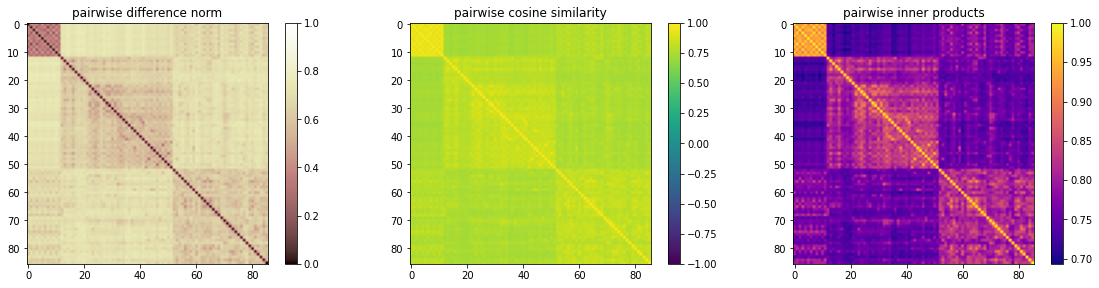

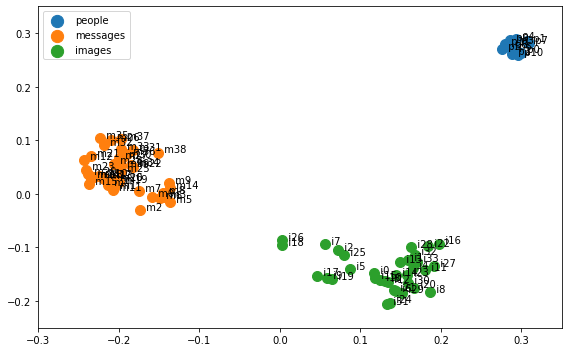

In [101]:
visualize_embeddings()

### Load content and compute embeddings

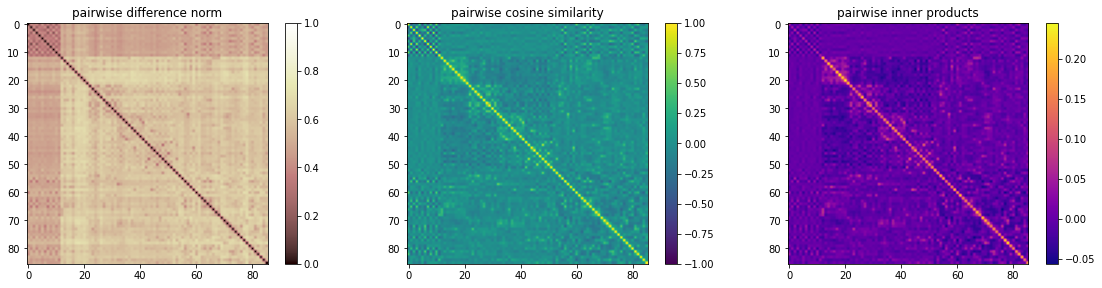

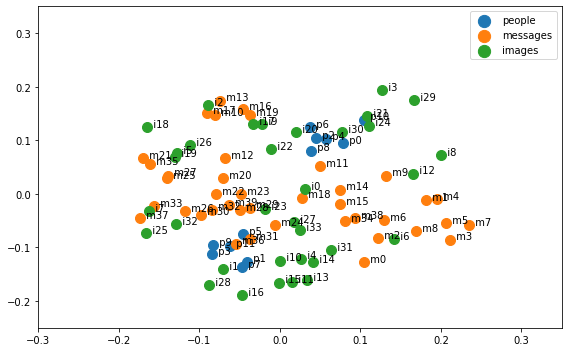

In [102]:
people = pd.read_csv('./data/people.csv')
messages = pd.read_csv('./data/messages.csv')
images = pd.read_csv('./data/images.csv')

for df in [people, messages, images]:
    df['embedding'] = df['content'].apply(get_embedding)
    center_embeddings(df)

visualize_embeddings()

### Compute recommendations

notes on people--images recommendations:
un-centered embeddings are shit

norm is too focused on demographics
cos/dot is better but does not distinguish between likes and dislikes

In [50]:
# people--images
get_recs(people, images, pref='cos', temp=.1)

probability distribution:
[[0.041 0.032 0.042 0.054 0.001 0.045 0.002 0.016 0.008 0.036 0.003 0.001
  0.014 0.    0.002 0.007 0.011 0.026 0.026 0.03  0.111 0.15  0.048 0.026
  0.022 0.02  0.026 0.001 0.003 0.073 0.015 0.008 0.02  0.002 0.079]
 [0.009 0.    0.004 0.01  0.001 0.003 0.001 0.001 0.533 0.004 0.002 0.001
  0.05  0.001 0.041 0.001 0.001 0.015 0.005 0.002 0.007 0.009 0.006 0.001
  0.013 0.    0.004 0.043 0.    0.03  0.191 0.001 0.    0.009 0.   ]
 [0.001 0.019 0.002 0.001 0.172 0.002 0.05  0.01  0.    0.002 0.027 0.133
  0.001 0.314 0.003 0.028 0.017 0.001 0.003 0.004 0.001 0.    0.001 0.009
  0.001 0.018 0.003 0.004 0.11  0.    0.    0.021 0.022 0.012 0.006]]


Gender: Male
Age: Adult
Race: White
Lifestyle: Moderate
Likes: Cats, Cooking, Drinking, Learning, Games
Dislikes: Sports, Homemaking, Design, Relaxing, Arts and Crafts

#21 (15%): Adult white man reading a book while sitting in the sea.
#20 (11%): Senior white man painting flowers on a canvas.
#34 ( 8%): Cat chef cooki

In [7]:
# messages--images
get_recs(messages, images, pref='cos', temp=1.)

probability distribution:
[[0.042 0.039 0.018 ... 0.047 0.028 0.027]
 [0.019 0.023 0.027 ... 0.032 0.022 0.029]
 [0.039 0.023 0.021 ... 0.027 0.021 0.017]
 ...
 [0.027 0.029 0.025 ... 0.027 0.032 0.038]
 [0.02  0.023 0.018 ... 0.035 0.024 0.048]
 [0.022 0.025 0.027 ... 0.031 0.026 0.037]]


Put on your favorite tunes and dance like nobody's watching! It's a fun way to get moving, express yourself, and let loose. Plus, you might just discover some new dance moves!

#14 ( 6%): Young adult African American woman listening to music, smiling, and fist pumping.
#15 ( 6%): Woman dancing with her dog at home.
#16 ( 5%): Young adult white woman dancing and cleaning the house.

#22 ( 2%): Adult asian man focusing on something indoors.
#2 ( 2%): Person with glasses filling out the newspaper crossword puzzle.
#21 ( 2%): Adult white man reading a book while sitting in the sea.


Take a break from your screen and hit the trails! Hiking is a great way to explore nature, get some exercise, and clear y

In [8]:
# people--messages
get_recs(people, messages, pref='cos', temp=1.)

probability distribution:
[[0.026 0.025 0.023 0.026 0.027 0.034 0.038 0.031 0.026 0.027 0.022 0.034
  0.018 0.026 0.029 0.023 0.024 0.023 0.028 0.024 0.019 0.023 0.022 0.027
  0.027 0.02  0.02  0.024 0.024 0.028 0.022 0.024 0.02  0.025 0.022 0.028
  0.021 0.023 0.024 0.023]
 [0.024 0.025 0.032 0.03  0.022 0.026 0.023 0.023 0.027 0.026 0.025 0.024
  0.025 0.023 0.033 0.025 0.023 0.025 0.02  0.022 0.024 0.023 0.024 0.022
  0.023 0.026 0.026 0.023 0.025 0.02  0.027 0.026 0.028 0.027 0.026 0.021
  0.027 0.027 0.025 0.027]
 [0.025 0.029 0.022 0.024 0.033 0.023 0.024 0.029 0.025 0.027 0.024 0.019
  0.027 0.023 0.015 0.026 0.025 0.024 0.028 0.028 0.026 0.024 0.025 0.022
  0.025 0.022 0.025 0.025 0.024 0.026 0.024 0.023 0.024 0.023 0.03  0.028
  0.023 0.023 0.031 0.026]
 [0.022 0.02  0.028 0.024 0.017 0.021 0.02  0.018 0.022 0.023 0.028 0.028
  0.026 0.027 0.036 0.024 0.026 0.027 0.021 0.023 0.029 0.03  0.025 0.026
  0.024 0.033 0.03  0.028 0.026 0.023 0.025 0.023 0.03  0.029 0.021 0.023
  0.0

### Embedding demographic and interests separately

In [103]:
def get_embedding_people(person):
    """Compute embeddings accounting for likes and dislikes"""
    demographics, likes, dislikes = person.replace('\nLikes: ', '|').replace('\nDislikes: ', '|').split('|')
    return get_embedding(demographics)


def include_interests(people):
    """Adjust embeddings for likes and dislikes"""
    for i in range(len(people)):
        person = people.loc[i].content
        _, likes, dislikes = person.replace('\nLikes: ', '|').replace('\nDislikes: ', '|').split('|')

        # positively adjust for likes
        for hobby in likes.split(', '):
            people.loc[i].embedding += .2 * get_embedding(hobby)

        # negatively adjust for dislikes
        for hobby in dislikes.split(', '):
            people.loc[i].embedding -= .2 * get_embedding(hobby)

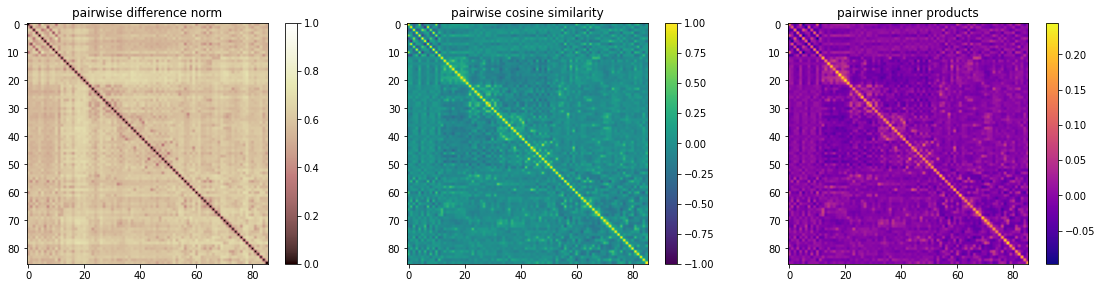

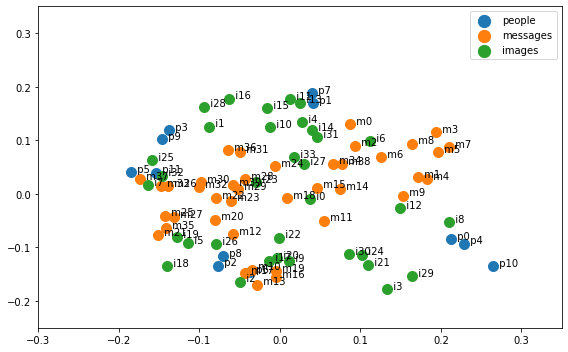

In [104]:
people = pd.read_csv('./data/people.csv')
messages = pd.read_csv('./data/messages.csv')
images = pd.read_csv('./data/images.csv')

for df in [messages, images]:
    df['embedding'] = df['content'].apply(get_embedding)
    center_embeddings(df)

# compute demographic embeddings
people['embedding'] = people['content'].apply(get_embedding_people)
center_embeddings(people)

# adjust for people's interests
include_interests(people)

visualize_embeddings()

In [64]:
get_recs(people, messages, pref='cos', temp=.1)

probability distribution:
[[0.012 0.023 0.009 0.018 0.036 0.024 0.049 0.027 0.013 0.019 0.037 0.053
  0.016 0.054 0.037 0.027 0.058 0.031 0.02  0.049 0.006 0.008 0.007 0.014
  0.018 0.005 0.002 0.005 0.007 0.015 0.018 0.05  0.004 0.007 0.014 0.005
  0.05  0.003 0.006 0.018 0.126]
 [0.036 0.064 0.014 0.04  0.097 0.054 0.061 0.087 0.051 0.04  0.025 0.048
  0.009 0.026 0.03  0.018 0.025 0.023 0.023 0.023 0.005 0.004 0.008 0.009
  0.018 0.003 0.002 0.005 0.013 0.015 0.004 0.013 0.003 0.006 0.025 0.006
  0.012 0.002 0.02  0.008 0.023]
 [0.024 0.052 0.026 0.073 0.033 0.033 0.026 0.038 0.043 0.068 0.029 0.016
  0.011 0.02  0.04  0.01  0.009 0.011 0.004 0.012 0.004 0.011 0.022 0.008
  0.024 0.014 0.016 0.01  0.04  0.008 0.02  0.03  0.015 0.022 0.042 0.013
  0.027 0.016 0.035 0.021 0.023]]


Gender: Male
Age: Adult
Race: White
Lifestyle: Moderate
Likes: Cats, Cooking, Drinking, Learning, Games
Dislikes: Sports, Homemaking, Design, Relaxing, Arts and Crafts

#40 (13%): Take a break from technolo

In [60]:
get_recs(people, images, pref='dot', temp=.1)

probability distribution:
[[0.031 0.03  0.032 0.033 0.025 0.029 0.025 0.022 0.031 0.033 0.021 0.023
  0.032 0.022 0.025 0.026 0.025 0.03  0.026 0.026 0.029 0.038 0.03  0.036
  0.032 0.03  0.03  0.025 0.023 0.036 0.029 0.027 0.026 0.025 0.034]
 [0.03  0.021 0.029 0.034 0.025 0.025 0.027 0.022 0.048 0.031 0.024 0.024
  0.035 0.025 0.036 0.025 0.022 0.031 0.027 0.023 0.024 0.031 0.028 0.027
  0.032 0.023 0.031 0.037 0.022 0.036 0.04  0.027 0.02  0.032 0.026]
 [0.023 0.033 0.024 0.024 0.042 0.023 0.036 0.03  0.02  0.026 0.034 0.04
  0.023 0.044 0.025 0.037 0.035 0.023 0.024 0.024 0.02  0.022 0.025 0.029
  0.025 0.034 0.025 0.027 0.037 0.021 0.02  0.033 0.029 0.032 0.031]]


Gender: Male
Age: Adult
Race: White
Lifestyle: Moderate
Likes: Cats, Cooking, Drinking, Learning, Games
Dislikes: Sports, Homemaking, Design, Relaxing, Arts and Crafts

#21 ( 4%): Adult white man reading a book while sitting in the sea.
#23 ( 4%): Middle-aged white woman drinking water at the table and looking down at s

In [17]:
get_recs(messages, images, pref='norm', temp=.1)

probability distribution:
[[0.033 0.033 0.014 ... 0.038 0.028 0.025]
 [0.019 0.021 0.02  ... 0.021 0.026 0.034]
 [0.03  0.029 0.016 ... 0.027 0.024 0.023]
 ...
 [0.021 0.028 0.021 ... 0.024 0.05  0.03 ]
 [0.02  0.02  0.016 ... 0.024 0.032 0.05 ]
 [0.02  0.028 0.024 ... 0.026 0.034 0.041]]


Put on your favorite tunes and dance like nobody's watching! It's a fun way to get moving, express yourself, and let loose. Plus, you might just discover some new dance moves!

#14 ( 8%): Young adult African American woman listening to music, smiling, and fist pumping.
#16 ( 8%): Young adult white woman dancing and cleaning the house.
#15 ( 7%): Woman dancing with her dog at home.

#26 ( 1%): Flatly with a notebook, coffee, glasses, and polaroids.
#18 ( 1%): A wooden desk with ink pens, books, and a notebook with handwriting practice.
#2 ( 1%): Person with glasses filling out the newspaper crossword puzzle.


Take a break from your screen and hit the trails! Hiking is a great way to explore nature, 

## Recommending tuples (person, image, message)

In [ ]:
if pref == 'norm':
    prefs = [[-np.linalg.norm(e1-e2) for e2 in df2.embedding] for e1 in df1.embedding]
elif pref == 'dot':
    prefs = [[np.dot(e1, e2) for e2 in df2.embedding] for e1 in df1.embedding]
elif pref == 'cos':
    prefs = [[np.dot(e1, e2) / (np.linalg.norm(e1) * np.linalg.norm(e2))\
          for e2 in df2.embedding] for e1 in df1.embedding]


In [120]:
def cossim(emb1, emb2):
    """Compute cosine similarity between two embeddings"""
    return np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))


def get_recs_tuple(pref='norm', temp=.1, k=5):
    """Normalize (person,message,image) proximity and return k best recommendations"""
    num_messages = len(messages)
    num_images = len(images)

    # compute normalized preferences
    people_prefs = []
    for p, person_emb in enumerate(people.embedding):
        prefs = np.zeros((num_messages, num_images))
        for i, message_emb in enumerate(messages.embedding):
            for j, image_emb in enumerate(images.embedding):

                if pref == 'norm':
                    prefs[i][j] = -np.linalg.norm(person_emb - message_emb)\
                                - np.linalg.norm(person_emb - image_emb)\
                                - 2*np.linalg.norm(message_emb - image_emb)
                elif pref == 'cos':
                    prefs[i][j] = cossim(person_emb, message_emb)\
                                + cossim(person_emb, image_emb)\
                                + 2*cossim(message_emb, image_emb)
                elif pref == 'dot':
                    prefs[i][j] = np.dot(person_emb, message_emb)\
                                + np.dot(person_emb, image_emb)\
                                + 1.5*np.dot(message_emb, image_emb)

        # normalize preferences
        probs = softmax(prefs.reshape(1,-1), temp=temp).reshape(num_messages, num_images)
        people_prefs.append(probs)

        # show k best recommendations for each person
        print(f'\n{people.loc[p].content}\n')
        for ii, jj in zip(*np.unravel_index(np.argsort(probs, axis=None)[-1:-k-1:-1], probs.shape)):
            print(f'#{jj}/#{ii} ({100*probs[ii][jj]:2.0f}%): '\
                  + f'{images.loc[jj].content}\n{messages.loc[ii].content}\n')
        print('\n================================================\n')

    return people_prefs

In [121]:
prefs = get_recs_tuple(pref='dot', temp=.01)


Gender: Male
Age: Young Adult
Race: African American
Lifestyle: Moderate
Likes: Sports, Outdoors, Learning, Exercise
Dislikes: Homemaking, Design, Relaxing, Arts and Crafts

#8/#4 (28%): Young adult African American man walking his dog in the park.
Step away from your screen and take a walk outside. Walking is a simple and accessible way to get some exercise, clear your mind, and enjoy the fresh air. Take a different route and see where it takes you!

#14/#0 (15%): Young adult African American woman listening to music, smiling, and fist pumping.
Put on your favorite tunes and dance like nobody's watching! It's a fun way to get moving, express yourself, and let loose. Plus, you might just discover some new dance moves!

#8/#7 (14%): Young adult African American man walking his dog in the park.
Put on your running shoes and hit the pavement! Jogging is a great way to improve your cardiovascular health, burn calories, and reduce stress. Start slow and steady, and work your way up!

#30/#

## Alternative way of adjusting for interests (Anton's idea)

In [20]:
people = pd.read_csv('./data/people.csv')
messages = pd.read_csv('./data/messages.csv')
images = pd.read_csv('./data/images.csv')
interests = pd.read_csv('./data/interests.csv')

for df in [messages, images, interests]:
    df['embedding'] = df['content'].apply(get_embedding)
    center_embeddings(df)

# compute demographic embeddings
people['embedding'] = people['content'].apply(get_embedding_people)
center_embeddings(people)

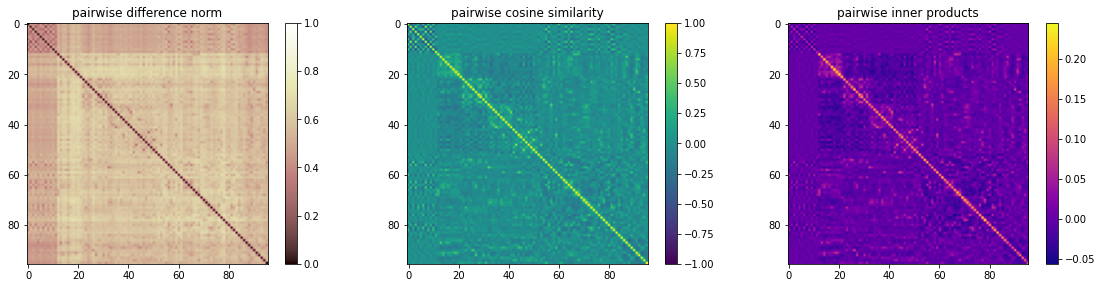

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


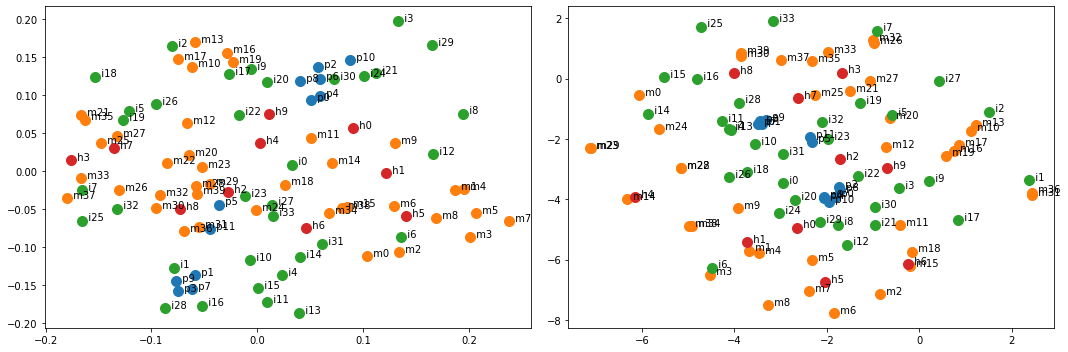

In [21]:
embs = np.array(people.embedding.tolist()\
              + messages.embedding.tolist()\
              + images.embedding.tolist()\
              + interests.embedding.tolist())

# row 1 -- pairwise differences
fig, ax = plt.subplots(1, 3, figsize=(16,4))

# plot embedding difference norm
emb_norm_diff = [[np.linalg.norm(e1-e2) for e2 in embs] for e1 in embs]
im0 = ax[0].imshow(emb_norm_diff, cmap='pink', vmin=0., vmax=1.)
ax[0].set_title('pairwise difference norm')
ax[0].grid(False)
plt.colorbar(im0, ax=ax[0])

# plot embedding cosine similarity
emb_cossim = [[np.dot(e1,e2)/(np.linalg.norm(e1)*np.linalg.norm(e2)) for e2 in embs] for e1 in embs]
im1 = ax[1].imshow(emb_cossim, cmap='viridis', vmin=-1., vmax=1.)
ax[1].set_title('pairwise cosine similarity')
ax[1].grid(False)
plt.colorbar(im1, ax=ax[1])

# plot embedding inner products
emb_dot = [[np.dot(e1,e2) for e2 in embs] for e1 in embs]
im2 = ax[2].imshow(emb_dot, cmap='plasma')#, vmin=-1., vmax=1.)
ax[2].set_title('pairwise inner products')
ax[2].grid(False)
plt.colorbar(im2, ax=ax[2])

plt.tight_layout()
plt.show()

# row 2 -- projection embeddings
fig, ax = plt.subplots(1, 2, figsize=(15,5))

# plot embedding pca
emb_pca = PCA(n_components=2).fit_transform(embs)
people_pca, messages_pca, images_pca, interests_pca =\
    np.split(emb_pca, [len(people), len(people)+len(messages), len(people)+len(messages)+len(images)])
# plot people pca
ax[0].scatter(people_pca[:,0], people_pca[:,1], s=100)
for ind, pnt in enumerate(people_pca):
    ax[0].annotate(f'  p{ind}', pnt)
# plot messages pca
ax[0].scatter(messages_pca[:,0], messages_pca[:,1], s=100)
for ind, pnt in enumerate(messages_pca):
    ax[0].annotate(f'  m{ind}', pnt)
# plot images pca
ax[0].scatter(images_pca[:,0], images_pca[:,1], s=100)
for ind, pnt in enumerate(images_pca):
    ax[0].annotate(f'  i{ind}', pnt)
# plot interests pca
ax[0].scatter(interests_pca[:,0], interests_pca[:,1], s=100)
for ind, pnt in enumerate(interests_pca):
    ax[0].annotate(f'  h{ind}', pnt)

# plot embedding tsne
emb_tsne = TSNE(n_components=2, init='pca', learning_rate='auto').fit_transform(embs)
people_tsne, messages_tsne, images_tsne, interests_tsne =\
    np.split(emb_tsne, [len(people), len(people)+len(messages), len(people)+len(messages)+len(images)])
# plot people tsne
ax[1].scatter(people_tsne[:,0], people_tsne[:,1], s=100)
for ind, pnt in enumerate(people_tsne):
    ax[1].annotate(f'  p{ind}', pnt)
# plot messages tsne
ax[1].scatter(messages_tsne[:,0], messages_tsne[:,1], s=100)
for ind, pnt in enumerate(messages_tsne):
    ax[1].annotate(f'  m{ind}', pnt)
# plot images tsne
ax[1].scatter(images_tsne[:,0], images_tsne[:,1], s=100)
for ind, pnt in enumerate(images_tsne):
    ax[1].annotate(f'  i{ind}', pnt)
# plot interests tsne
ax[1].scatter(interests_tsne[:,0], interests_tsne[:,1], s=100)
for ind, pnt in enumerate(interests_tsne):
    ax[1].annotate(f'  h{ind}', pnt)

plt.tight_layout()
plt.show()

In [22]:
hobbies = {}
for i in range(len(interests)):
    hobbies[interests.loc[i].interest] = interests.loc[i].embedding

In [23]:
hobbies

{'Sports': array([-0.006,  0.   ,  0.008, ..., -0.019, -0.007,  0.004]),
 'Outdoors': array([ 0.018,  0.003, -0.002, ...,  0.001, -0.008, -0.006]),
 'Indoors': array([ 0.013, -0.003, -0.003, ...,  0.008, -0.003, -0.005]),
 'Arts and Crafts': array([-0.015, -0.005, -0.016, ...,  0.02 ,  0.01 , -0.007]),
 'Learning': array([-0.   ,  0.001,  0.013, ..., -0.007,  0.003,  0.014]),
 'Exercise': array([-0.01 , -0.006, -0.003, ...,  0.005,  0.005,  0.007]),
 'Relaxing': array([0.002, 0.013, 0.024, ..., 0.003, 0.002, 0.008]),
 'Design': array([ 0.017,  0.001, -0.005, ..., -0.   , -0.002, -0.001]),
 'Homemaking': array([ 0.001, -0.014, -0.018, ...,  0.007,  0.003, -0.002]),
 'Games': array([-0.018,  0.009,  0.001, ..., -0.02 , -0.003, -0.013])}

In [24]:
def include_hobbies(people):
    """Adjust embeddings for likes and dislikes"""
    for i in range(len(people)):
        person = people.loc[i].content
        _, likes, dislikes = person.replace('\nLikes: ', '|').replace('\nDislikes: ', '|').split('|')

        # positively adjust for likes
        for hobby in likes.split(', '):
            people.loc[i].embedding += .2 * hobbies[hobby]

        # negatively adjust for dislikes
        for hobby in dislikes.split(', '):
            people.loc[i].embedding -= .2 * hobbies[hobby]

In [25]:
people

,content,embedding
0,Gender: Male\nAge: Young Adult\nRace: African ...,"[-0.0008074383173758788, -0.006545474262869296..."
1,Gender: Female\nAge: Adult\nRace: Asian\nLifes...,"[-0.0044467726644749446, 0.004669780401551786,..."
2,Gender: Male\nAge: Senior\nRace: Hispanic\nLif...,"[0.004825443921921154, 0.0003404589612424995, ..."
3,Gender: Female\nAge: Young Adult\nRace: Asian\...,"[-0.004784170344161491, 0.002646571456959161, ..."
4,Gender: Male\nAge: Adult\nRace: White\nLifesty...,"[0.003532017076698442, -0.004619112214034733, ..."
5,Gender: Female\nAge: Middle-aged\nRace: Hispan...,"[-0.00235676559774826, 0.019080996071958605, -..."
6,Gender: Male\nAge: Senior\nRace: White\nLifest...,"[0.002553267132801314, -0.012200609290933547, ..."
7,Gender: Female\nAge: Young Adult\nRace: Asian\...,"[-0.0066498730254049105, 0.0037803373076409725..."
8,Gender: Male\nAge: Adult\nRace: African Americ...,"[0.008106518730831642, -0.005763920931106743, ..."
9,Gender: Female\nAge: Middle-aged\nRace: Asian\...,"[-0.0019495773982877536, 0.008281371114814343,..."


In [26]:
include_hobbies(people)

In [27]:
people

,content,embedding
0,Gender: Male\nAge: Young Adult\nRace: African ...,"[-0.001451641453119616, -0.00605702926016723, ..."
1,Gender: Female\nAge: Adult\nRace: Asian\nLifes...,"[-0.000992506688150266, -0.002551005869948615,..."
2,Gender: Male\nAge: Senior\nRace: Hispanic\nLif...,"[0.001193050116611023, -0.0009487290420414263,..."
3,Gender: Female\nAge: Young Adult\nRace: Asian\...,"[-0.01099612288332234, 0.0034932827906838325, ..."
4,Gender: Male\nAge: Adult\nRace: White\nLifesty...,"[-0.0007252046760792541, -0.002536500241452206..."
5,Gender: Female\nAge: Middle-aged\nRace: Hispan...,"[-0.00598915940305839, 0.01779180806867468, -0..."
6,Gender: Male\nAge: Senior\nRace: White\nLifest...,"[0.0027120197735105945, -0.006573989989313606,..."
7,Gender: Female\nAge: Young Adult\nRace: Asian\...,"[-0.0031956070490802317, -0.003440448963859429..."
8,Gender: Male\nAge: Adult\nRace: African Americ...,"[0.0044741249255215105, -0.007053108934390669,..."
9,Gender: Female\nAge: Middle-aged\nRace: Asian\...,"[-0.0081615299374486, 0.009128082448539016, -0..."


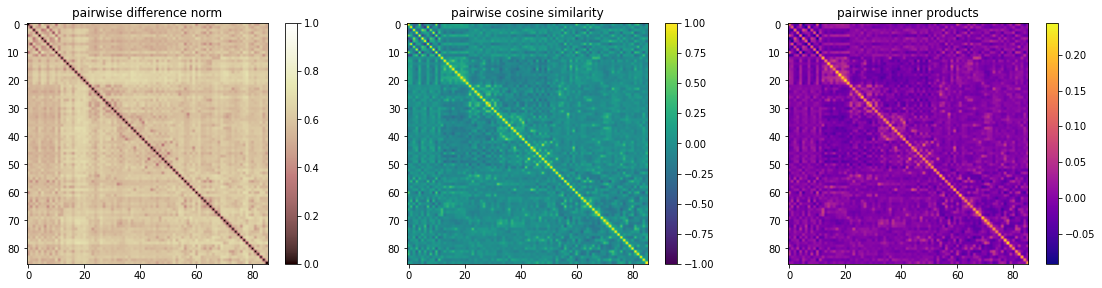

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


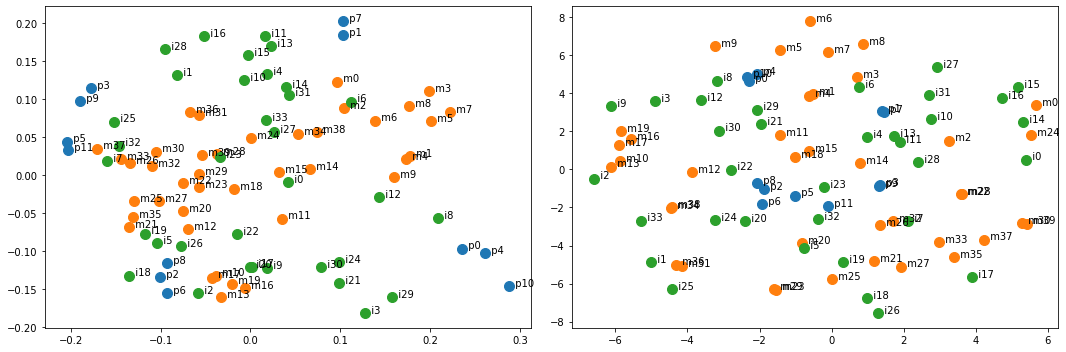

In [28]:
visualize_embeddings()

In [29]:
get_recs(people, messages, k=5, pref='norm', temp=.1)

probability distribution:
[[0.023 0.049 0.02  0.024 0.052 0.027 0.021 0.034 0.021 0.027 0.023 0.038
  0.028 0.03  0.025 0.025 0.029 0.025 0.028 0.024 0.026 0.026 0.021 0.022
  0.025 0.016 0.015 0.019 0.024 0.021 0.016 0.021 0.02  0.018 0.034 0.024
  0.019 0.015 0.028 0.017]
 [0.021 0.046 0.024 0.03  0.042 0.023 0.019 0.026 0.021 0.028 0.027 0.026
  0.032 0.026 0.021 0.022 0.023 0.022 0.018 0.018 0.024 0.028 0.024 0.019
  0.025 0.019 0.019 0.021 0.031 0.017 0.025 0.028 0.023 0.02  0.037 0.022
  0.027 0.019 0.031 0.026]
 [0.016 0.019 0.014 0.012 0.025 0.011 0.01  0.012 0.01  0.011 0.025 0.026
  0.052 0.029 0.014 0.033 0.022 0.022 0.041 0.029 0.036 0.033 0.03  0.022
  0.026 0.017 0.028 0.02  0.022 0.029 0.041 0.033 0.04  0.025 0.03  0.03
  0.029 0.031 0.019 0.027]
 [0.015 0.015 0.013 0.012 0.016 0.01  0.008 0.01  0.01  0.015 0.025 0.029
  0.041 0.027 0.029 0.018 0.026 0.028 0.027 0.027 0.033 0.049 0.029 0.028
  0.021 0.038 0.034 0.025 0.027 0.022 0.022 0.027 0.044 0.04  0.025 0.037
  0.02

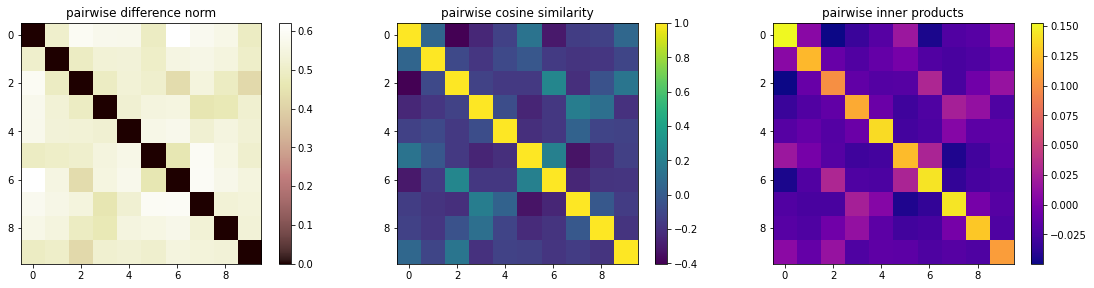

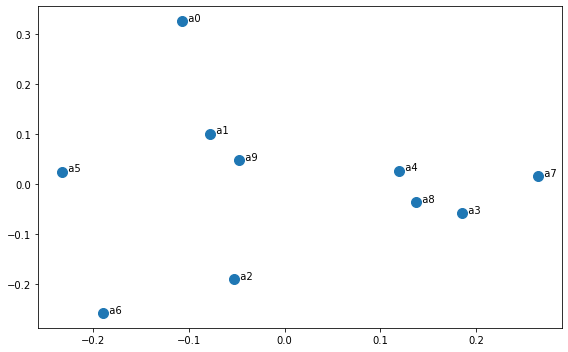

In [30]:
embs = np.array(interests.embedding.tolist())


# row 1 -- pairwise differences
fig, ax = plt.subplots(1, 3, figsize=(16,4))

# plot embedding difference norm
emb_norm_diff = [[np.linalg.norm(e1-e2) for e2 in embs] for e1 in embs]
im0 = ax[0].imshow(emb_norm_diff, cmap='pink')#, vmin=0., vmax=1.)
ax[0].set_title('pairwise difference norm')
ax[0].grid(False)
plt.colorbar(im0, ax=ax[0])

# plot embedding cosine similarity
emb_cossim = [[np.dot(e1,e2)/(np.linalg.norm(e1)*np.linalg.norm(e2)) for e2 in embs] for e1 in embs]
im1 = ax[1].imshow(emb_cossim, cmap='viridis')#, vmin=-1., vmax=1.)
ax[1].set_title('pairwise cosine similarity')
ax[1].grid(False)
plt.colorbar(im1, ax=ax[1])

# plot embedding inner products
emb_dot = [[np.dot(e1,e2) for e2 in embs] for e1 in embs]
im2 = ax[2].imshow(emb_dot, cmap='plasma')#, vmin=-1., vmax=1.)
ax[2].set_title('pairwise inner products')
ax[2].grid(False)
plt.colorbar(im2, ax=ax[2])

plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(8,5))
emb_pca = PCA(n_components=2).fit_transform(embs)
ax.scatter(emb_pca[:,0], emb_pca[:,1], s=100)
for ind, pnt in enumerate(emb_pca):
    ax.annotate(f'  a{ind}', pnt)
plt.tight_layout()
plt.show()

In [31]:
interests

,content,interest,embedding
0,"""Physical activities that involve competition,...",Sports,"[-0.006242487789131701, 0.0002996824085130358,..."
1,"""Activities that take place outside, such as h...",Outdoors,"[0.017938947095535694, 0.0026698072222643534, ..."
2,"""Activities that take place inside, such as re...",Indoors,"[0.013291936158202589, -0.002597246285586152, ..."
3,"""Activities that involve creating something by...",Arts and Crafts,"[-0.015372856729663908, -0.005020824693201575,..."
4,"""Activities that involve acquiring new knowled...",Learning,"[-0.00035152325872331866, 0.001131281522975769..."
5,"""Physical activities that involve movement and...",Exercise,"[-0.010393103794194758, -0.006132093690393958,..."
6,"""Activities that promote relaxation and stress...",Relaxing,"[0.0015219028806313871, 0.013434781260730232, ..."
7,"""Activities that involve creating or improving...",Design,"[0.017161698802374302, 0.0012688751201494599, ..."
8,"""Activities that involve managing and maintain...",Homemaking,"[0.000862102978862822, -0.014156379237829243, ..."
9,"""Activities that involve playing games, such a...",Games,"[-0.018416616343893112, 0.009102116372378077, ..."
